In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
import datetime as dt


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Fix Discontinuity

The given temporal data is not continuous. So we fragmented it into continuous data.


In [ ]:
labeled_field = pd.read_pickle("labeled_field.pkl", compression="gzip")
labeled_field.head()


,user_id,activity_type_id,start,finish,X,Y,Z,T
0,4,5,2018-12-02 10:27:37,2018-12-02 10:28:22,"[-2.221, 1.455, 1.455, 0.574, 2.26, 2.26, -2.3...","[7.776, 7.125, 7.125, 6.205, 5.171, 5.171, 7.5...","[6.3660000000000005, 5.89, 5.89, 6.653, 7.721,...","[2018-12-02T10:27:37.041000000, 2018-12-02T10:..."
1,4,5,2018-12-02 10:32:58,2018-12-02 10:33:29,"[1.187, 1.187, 1.838, 1.838, 3.217, 1.992, 1.9...","[5.478, 5.478, 5.2860000000000005, 5.286000000...","[8.329, 8.329, 8.087, 8.087, 7.975, 6.025, 6.0...","[2018-12-02T10:32:58.181000000, 2018-12-02T10:..."
2,4,4,2018-12-02 10:33:31,2018-12-02 10:34:25,"[-1.6469999999999998, -1.6469999999999998, 1.0...","[7.928999999999999, 7.928999999999999, 9.577, ...","[2.707, 2.707, 1.851, 0.5329999999999999, -0.1...","[2018-12-02T10:33:45.575000000, 2018-12-02T10:..."
3,4,5,2018-12-02 10:34:29,2018-12-02 10:35:09,"[3.486, 3.486, 5.631, 3.447, 1.225, 2.068, 2.0...","[10.036, 10.036, 9.04, 7.24, 7.891, 5.631, 5.6...","[0.484, 0.484, 0.064, 0.049, 2.076, 6.852, 6.8...","[2018-12-02T10:34:41.983000000, 2018-12-02T10:..."
4,4,4,2018-12-02 11:49:03,2018-12-02 11:50:02,"[-5.746, -5.401, -5.401, -5.669, -5.8610000000...","[7.853, 7.622999999999999, 7.622999999999999, ...","[0.127, 0.124, 0.124, 0.107, 0.115, 0.16, 0.16...","[2018-12-02T11:49:03.051000000, 2018-12-02T11:..."


In [ ]:
labeled_field.dtypes


user_id                      int64
activity_type_id             int64
start               datetime64[ns]
finish              datetime64[ns]
X                           object
Y                           object
Z                           object
T                           object
dtype: object

In [ ]:
bp = [0]  # breakpoints
added = 0
for i in range(len(labeled_field)):
    for j in range(1, len(labeled_field.loc[i, "T"])):
        # if the difference between two consecutive values is greater than 2s, add a breakpoint
        if (
            (labeled_field.loc[i, "T"][j] - labeled_field.loc[i, "T"][j - 1])
            / np.timedelta64(1, "s")
        ) >= 2:
            bp.append(j)
    bp.append(len(labeled_field.loc[i, "T"]))
    if (
        len(bp) > 2
    ):  # if there are more than two discontinuities including start and end
        for k in range(1, len(bp)):
            newdf = pd.DataFrame(
                {
                    "user_id": [labeled_field.loc[i, "user_id"]],
                    "activity_type_id": [labeled_field.loc[i, "activity_type_id"]],
                    "start": [pd.to_datetime(labeled_field.loc[i, "T"][bp[k - 1]])],
                    "finish": [pd.to_datetime(labeled_field.loc[i, "T"][bp[k] - 1])],
                    "X": [labeled_field.loc[i, "X"][bp[k - 1] : bp[k]]],
                    "Y": [labeled_field.loc[i, "Y"][bp[k - 1] : bp[k]]],
                    "Z": [labeled_field.loc[i, "Z"][bp[k - 1] : bp[k]]],
                    "T": [labeled_field.loc[i, "T"][bp[k - 1] : bp[k]]],
                }
            )
            labeled_field = pd.concat([labeled_field, newdf], ignore_index=True)
        added += len(bp) - 2
        print(f"index{i} dropped")
        labeled_field.drop(i)
    bp = [0]
print("Total", added, "row added")


In [ ]:
labeled_field["length"] = labeled_field["T"].apply(len)
labeled_field.head()


,user_id,activity_type_id,start,finish,X,Y,Z,Time,length
0,18,9,2018-12-01 22:50:29,2018-12-01 22:51:16,"[-1.0761912191930145, -1.2996604335255786, -1....","[7.278006110899289, 7.314203359813134, 7.34684...","[3.3749311576590486, 3.374820581767359, 3.3656...","[2018-12-01T22:50:30.450000000, 2018-12-01T22:...",800
1,18,9,2018-12-01 23:29:35,2018-12-01 23:30:09,"[1.3620586299434982, 1.3607741168026488, 1.360...","[7.704226326846039, 7.753452679488208, 7.80137...","[0.09263532439116798, 0.7122787723283562, 1.31...","[2018-12-01T23:29:55.700000000, 2018-12-01T23:...",265
2,18,10,2018-12-01 23:46:32,2018-12-01 23:47:20,"[-4.22142105868042, -4.228173445447816, -4.232...","[4.633118408576495, 4.776392928058909, 4.92265...","[2.2883405806148702, 2.64521618074148, 2.98787...","[2018-12-01T23:46:33.650000000, 2018-12-01T23:...",921
3,18,9,2018-12-01 23:58:27,2018-12-01 23:59:03,"[0.011176190391082773, -0.12869343186136828, -...","[8.655850321930386, 8.76944554480367, 8.877926...","[3.977220032950275, 4.223088201691081, 4.45847...","[2018-12-01T23:58:27.250000000, 2018-12-01T23:...",670
4,4,5,2018-12-02 10:27:37,2018-12-02 10:28:22,"[0.10783071488709874, 0.3303105412467751, 0.54...","[7.093423475561911, 6.999542499158988, 6.90472...","[5.846058082782215, 5.935895343189449, 6.04110...","[2018-12-02T10:27:37.000000000, 2018-12-02T10:...",898


In [ ]:
labeled_field = labeled_field[labeled_field["length"] >= 60].sort_values(
    "start", ignore_index=True
)
labeled_field.head()


,user_id,activity_type_id,start,finish,X,Y,Z,T,length
0,18,9,2018-12-01 22:50:29.000,2018-12-01 22:51:16.000,"[-5.171, -3.7539999999999996, -1.072, -1.072, ...","[7.278, 8.274, 8.81, 8.81, 8.351, 6.665, 6.665...","[3.39, 3.373, 3.633, 3.633, 3.8489999999999998...","[2018-12-01T22:50:30.481000000, 2018-12-01T22:...",95
1,18,9,2018-12-01 23:29:35.000,2018-12-01 23:30:09.000,"[1.5319999999999998, 2.451, 1.379, 1.379, -3.1...","[7.7, 7.776, 8.581, 8.581, 8.236, 7.814, 7.814...","[0.105, 4.154, 3.387, 3.387, 4.565, 6.41299999...","[2018-12-01T23:29:55.742000000, 2018-12-01T23:...",99
2,18,10,2018-12-01 23:46:32.000,2018-12-01 23:47:20.000,"[-6.091, -5.784, -4.213, -4.213, 4.252, 9.692,...","[7.776, 6.32, 4.635, 4.635, 11.492, 18.043, 8....","[2.2840000000000003, 4.202, 6.09, 6.09, -6.332...","[2018-12-01T23:46:33.656000000, 2018-12-01T23:...",74
3,18,9,2018-12-01 23:58:27.000,2018-12-01 23:59:03.000,"[-0.7659999999999999, -0.7659999999999999, 0.2...","[9.347000000000001, 9.347000000000001, 8.657, ...","[5.462000000000001, 5.462000000000001, 3.97, 5...","[2018-12-01T23:58:27.272000000, 2018-12-01T23:...",156
4,18,9,2018-12-01 23:58:41.989,2018-12-01 23:58:43.539,"[2.068, 2.068, 2.221, 0.804, -0.153, -0.153, -...","[8.427, 8.427, 8.312000000000001, 7.125, 6.895...","[5.845, 5.845, 5.329, 5.662000000000001, 5.85,...","[2018-12-01T23:58:41.989000000, 2018-12-01T23:...",66


# Median Filter


In [ ]:
labeled_field["MF_X"] = labeled_field["X"].apply(signal.medfilt, kernel_size=5)
labeled_field["MF_Y"] = labeled_field["Y"].apply(signal.medfilt, kernel_size=5)
labeled_field["MF_Z"] = labeled_field["Z"].apply(signal.medfilt, kernel_size=5)
len(labeled_field.loc[0, "MF_X"])


95

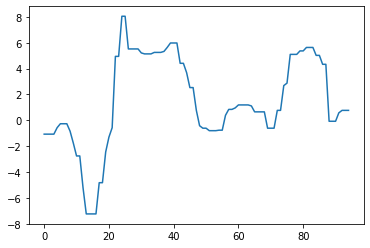

In [ ]:
plt.plot(labeled_field.loc[0, "MF_X"])


In [ ]:
labeled_field.to_pickle("mf_labeled_field.pkl", compression="gzip")


# Resampling


In [ ]:
rsx = []
rsy = []
rsz = []
rst = []
for i in labeled_field.index:
    df = pd.DataFrame(
        {
            "x": labeled_field.MF_X[i],
            "y": labeled_field.MF_Y[i],
            "z": labeled_field.MF_Z[i],
            "t": labeled_field.loc[i, "T"],
        }
    )
    df.set_index("t", inplace=True)
    resampled = df.resample("50ms").bfill(limit=1).interpolate(method="linear")
    rsx.append(np.array(resampled["x"]))
    rsy.append(np.array(resampled["y"]))
    rsz.append(np.array(resampled["z"]))
    rst.append(np.array(resampled.index))
labeled_field["X"], labeled_field["Y"], labeled_field["Z"], labeled_field["Time"] = (
    rsx,
    rsy,
    rsz,
    rst,
)


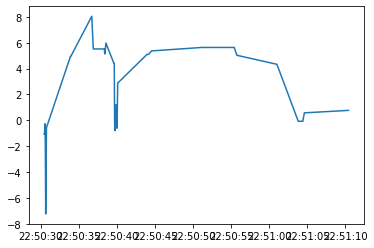

In [ ]:
plt.plot(labeled_field.loc[0, "Time"], labeled_field.loc[0, "X"])


Text(0.5, 0.98, 'Resampling at 20Hz Method: linear Example: 1000')

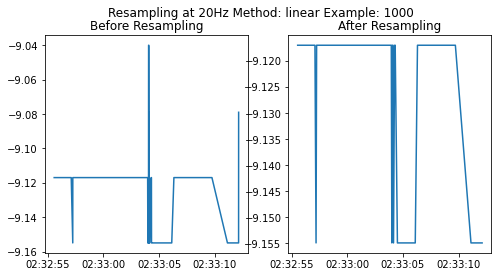

In [ ]:
method = "linear"
example = 1000
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(labeled_field.loc[example, "T"], labeled_field.loc[example, "MF_X"])
plt.title("Before Resampling")
plt.subplot(1, 2, 2)
plt.plot(labeled_field.loc[example, "Time"], labeled_field.loc[example, "X"])
plt.title("After Resampling")
plt.gcf().suptitle(f"Resampling at 20Hz Method: {method} Example: {example}")


In [ ]:
labeled_field["length"] = labeled_field["Time"].apply(len)
labeled_field = labeled_field[labeled_field["length"] >= 60].sort_values(
    "start", ignore_index=True
)
labeled_field.head(), len(labeled_field)


(   user_id  ...                                               Time
 0       18  ...  [2018-12-01T22:50:30.450000000, 2018-12-01T22:...
 1       18  ...  [2018-12-01T23:29:55.700000000, 2018-12-01T23:...
 2       18  ...  [2018-12-01T23:46:33.650000000, 2018-12-01T23:...
 3       18  ...  [2018-12-01T23:58:27.250000000, 2018-12-01T23:...
 4        4  ...  [2018-12-02T10:27:37.000000000, 2018-12-02T10:...
 
 [5 rows x 13 columns], 3186)

In [ ]:
labeled_field.drop(columns=["T", "MF_X", "MF_Y", "MF_Z", "length"], inplace=True)
labeled_field


,user_id,activity_type_id,start,finish,X,Y,Z,Time
0,18,9,2018-12-01 22:50:29.000,2018-12-01 22:51:16.000,"[-1.072, -1.072, -0.268, -1.7619999999999998, ...","[7.278, 8.351, 6.665, 6.972, 8.198, 8.198, 7.2...","[3.373, 3.633, 3.924, 3.966, 5.383999999999999...","[2018-12-01T22:50:30.450000000, 2018-12-01T22:..."
1,18,9,2018-12-01 23:29:35.000,2018-12-01 23:30:09.000,"[1.379, 1.379, 1.379, 1.379, 1.379, 1.379, 1.3...","[7.7, 7.719, 7.7379999999999995, 7.757, 7.776,...","[0.105, 0.9255, 1.746, 2.5665, 3.387, 3.387, 3...","[2018-12-01T23:29:55.700000000, 2018-12-01T23:..."
2,18,10,2018-12-01 23:46:32.000,2018-12-01 23:47:20.000,"[-4.213, -4.213, -4.213, -4.213, -4.213, -4.21...","[4.635, 4.635, 4.635, 4.635, 4.635, 5.05625, 5...","[2.2840000000000003, 2.7635, 3.243000000000000...","[2018-12-01T23:46:33.650000000, 2018-12-01T23:..."
3,18,9,2018-12-01 23:58:27.000,2018-12-01 23:59:03.000,"[0.0, -0.19149999999999998, -0.382999999999999...","[8.657, 8.8295, 9.002, 9.174500000000002, 9.34...","[3.97, 4.343, 4.716, 5.089, 5.462000000000001,...","[2018-12-01T23:58:27.250000000, 2018-12-01T23:..."
4,4,5,2018-12-02 10:27:37.000,2018-12-02 10:28:22.000,"[0.0, 0.1435, 0.287, 0.4305, 0.574, 0.79425, 1...","[7.125, 7.125, 7.125, 7.125, 7.125, 6.895, 6.6...","[5.89, 5.89, 5.89, 5.89, 5.89, 6.08075, 6.2715...","[2018-12-02T10:27:37.000000000, 2018-12-02T10:..."
...,...,...,...,...,...,...,...,...
3181,4,4,2018-12-31 21:42:01.521,2018-12-31 22:31:57.956,"[0.6890000000000001, 0.6890000000000001, 0.689...","[8.158999999999999, 8.389, 8.619, 8.849, 9.079...","[0.055, 0.0755, 0.096, 0.11649999999999999, 0....","[2018-12-31T21:42:01.500000000, 2018-12-31T21:..."
3182,8,1,2019-01-01 06:06:45.000,2019-01-01 06:07:37.000,"[-2.681, -2.70025, -2.7195, -2.73875, -2.758, ...","[7.125, 7.1825, 7.24, 7.2975, 7.355, 7.355, 7....","[5.78, 5.785, 5.79, 5.795, 5.8, 5.801, 5.802, ...","[2019-01-01T06:06:45.150000000, 2019-01-01T06:..."
3183,8,1,2019-01-01 06:06:45.159,2019-01-01 06:07:04.190,"[-2.681, -2.70025, -2.7195, -2.73875, -2.758, ...","[7.125, 7.1825, 7.24, 7.2975, 7.355, 7.355, 7....","[5.78, 5.785, 5.79, 5.795, 5.8, 5.801, 5.802, ...","[2019-01-01T06:06:45.150000000, 2019-01-01T06:..."
3184,8,1,2019-01-01 06:07:06.784,2019-01-01 06:07:21.811,"[-5.171, -5.171, -5.171, -5.171, -5.171, -4.99...","[8.312000000000001, 8.312000000000001, 8.31200...","[0.026000000000000002, 0.11900000000000001, 0....","[2019-01-01T06:07:06.750000000, 2019-01-01T06:..."


In [ ]:
labeled_field.Time.apply(len)


0         800
1         265
2         921
3         670
4         898
        ...  
3181    59930
3182     1037
3183      381
3184      302
3185      521
Name: Time, Length: 3186, dtype: int64

# Low Pass Filter


In [ ]:
fs = 20
fc = 1
lpx, lpy, lpz = [], [], []
for i in range(len(labeled_field)):
    b, a = signal.butter(3, fc / (fs / 2))
    lpx.append(signal.filtfilt(b, a, labeled_field.loc[i, "X"]))
    lpy.append(signal.filtfilt(b, a, labeled_field.loc[i, "Y"]))
    lpz.append(signal.filtfilt(b, a, labeled_field.loc[i, "Z"]))
labeled_field["X"] = lpx
labeled_field["Y"] = lpy
labeled_field["Z"] = lpz
labeled_field


,user_id,activity_type_id,start,finish,X,Y,Z,Time
0,18,9,2018-12-01 22:50:29.000,2018-12-01 22:51:16.000,"[-1.0761912191930145, -1.2996604335255786, -1....","[7.278006110899289, 7.314203359813134, 7.34684...","[3.3749311576590486, 3.374820581767359, 3.3656...","[2018-12-01T22:50:30.450000000, 2018-12-01T22:..."
1,18,9,2018-12-01 23:29:35.000,2018-12-01 23:30:09.000,"[1.3620586299434982, 1.3607741168026488, 1.360...","[7.704226326846039, 7.753452679488208, 7.80137...","[0.09263532439116798, 0.7122787723283562, 1.31...","[2018-12-01T23:29:55.700000000, 2018-12-01T23:..."
2,18,10,2018-12-01 23:46:32.000,2018-12-01 23:47:20.000,"[-4.22142105868042, -4.228173445447816, -4.232...","[4.633118408576495, 4.776392928058909, 4.92265...","[2.2883405806148702, 2.64521618074148, 2.98787...","[2018-12-01T23:46:33.650000000, 2018-12-01T23:..."
3,18,9,2018-12-01 23:58:27.000,2018-12-01 23:59:03.000,"[0.011176190391082773, -0.12869343186136828, -...","[8.655850321930386, 8.76944554480367, 8.877926...","[3.977220032950275, 4.223088201691081, 4.45847...","[2018-12-01T23:58:27.250000000, 2018-12-01T23:..."
4,4,5,2018-12-02 10:27:37.000,2018-12-02 10:28:22.000,"[0.10783071488709874, 0.3303105412467751, 0.54...","[7.093423475561911, 6.999542499158988, 6.90472...","[5.846058082782215, 5.935895343189449, 6.04110...","[2018-12-02T10:27:37.000000000, 2018-12-02T10:..."
...,...,...,...,...,...,...,...,...
3181,4,4,2018-12-31 21:42:01.521,2018-12-31 22:31:57.956,"[0.6851923536482255, 0.5684014395190181, 0.451...","[8.161065628785742, 8.326018070934893, 8.48237...","[0.04649090115298744, 0.05434191035399382, 0.0...","[2018-12-31T21:42:01.500000000, 2018-12-31T21:..."
3182,8,1,2019-01-01 06:06:45.000,2019-01-01 06:07:37.000,"[-2.7015867089907295, -2.719283823353232, -2.7...","[7.128262914181074, 7.168860704132462, 7.20713...","[5.7469729274068015, 5.748581437728416, 5.7533...","[2019-01-01T06:06:45.150000000, 2019-01-01T06:..."
3183,8,1,2019-01-01 06:06:45.159,2019-01-01 06:07:04.190,"[-2.7015867089907295, -2.719283823353232, -2.7...","[7.128262914181106, 7.168860704132498, 7.20713...","[5.7469729274067936, 5.74858143772841, 5.75333...","[2019-01-01T06:06:45.150000000, 2019-01-01T06:..."
3184,8,1,2019-01-01 06:07:06.784,2019-01-01 06:07:21.811,"[-5.154398218490344, -5.090425027100808, -5.02...","[8.292082603058383, 8.20262167623543, 8.112456...","[0.022421086240968422, 0.06116496331737013, 0....","[2019-01-01T06:07:06.750000000, 2019-01-01T06:..."


In [ ]:
labeled_field.to_pickle("lpfiltered_labeled_field.pkl", compression="gzip")
